# Basics of Mobile Robotics Project EPFL 2020

Members: Celinna Ju, Mickaël Achkar, Kevin Qiu, Joachim Honegger

In [2]:
#you can install the libraries through the requirement.txt file
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image

sys.path.insert(0, os.path.join(os.getcwd(), 'utils'))
sys.path.insert(0, os.path.join(os.getcwd(), 'camera'))
sys.path.insert(0, os.path.join(os.getcwd(), 'global_nav'))

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

# Introduction
The COVID-19 pandemic has been a big part of the lives of people around the world. EPFL students had to transition from in-person to online learning in 2020. This has been a difficult time for many people. A vaccine for the coronavirus will enable people to slowly return to normal life. As students, we wish to be able to attend classes in person again, socialize with friends freely, and enjoy our university experience. With this in mind, we decided to create an environment where the Thymio will be finding the vaccine for the coronavirus. 

Project demonstration video
<video width="900" controls src="video/project_demonstration.mp4" />

Thymio kidnapping demonstration video
<video width="900" controls src="video/thymio_kidnapping_demonstration.mp4" />

#Summary

In this project, we implemented several image processing methods including adaptive thresholding, morphology, and template matching. Then we compared several path planning algorithms: A*, Voronoi diagrams, Probabilistic road maps (PRM) and Rapidly-exploring random trees (RRT). After the comparison we decided to use Voronoi diagrams. Then, we added motion control methods to easily control the Thymio and avoid obstacles locally. Additionally, we implemented the extended Kalman filter (EKF) to correct the speed of the wheels. Finally, we added live camera positioning using ArUco markers to correct the position and angle of the Thymio.

# 1. Environment

## Image processing (get_corners from unwarp.py)
Due to the limited resolution of the webcam we had, we decided to use a fairly small map as the environment. The map is constructed out of white paper, and the obstacles are made out of black paper. A video of the map is taken with a webcam. Since the camera sees the map at a slight angle, we need to flatten the image in order to have a more accurate idea of the robot's location. This is done through image processing. Initially, a single image of the empty map is taken in order to find the four corners of the map. The following steps are done to process the image before the corners can be found:
1. Convert image to grayscale
2. Do adaptive threshold on gray image
3. Apply morphology
4. Separate then combine horizontal and vertical to filter out spots outside of the rectangle
5. Remove specks and spots in the image below a threshold area
6. Get largest contour in image
7. Get the corners of the contour

The algorithm requires all four corners of the map to be clearly seen in the source image. Other obstacles such as the Thymio and random obstacles will not affect the detection of the map countour and corners as long as they are contained within the map. 


Text(0.5, 1.0, 'Result')

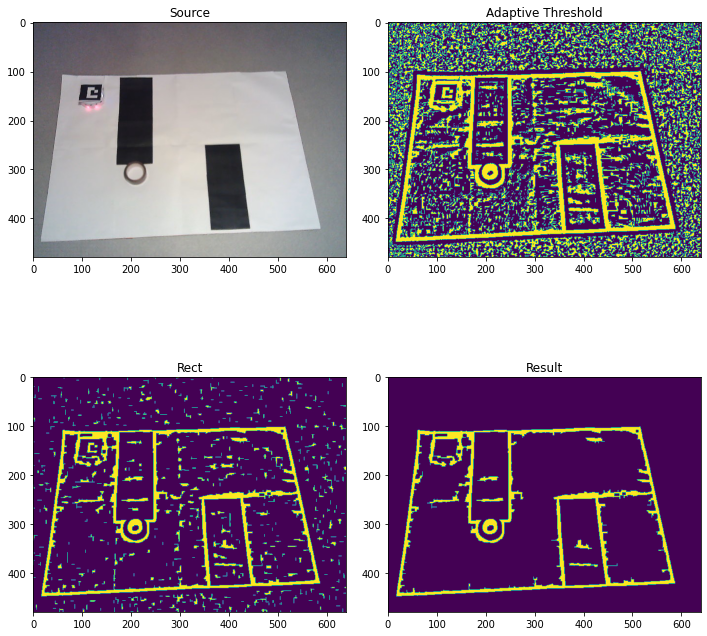

In [3]:
%matplotlib inline

raw = mpimg.imread("camera/raw_map.jpg")
rect = mpimg.imread("report_plots/rectangle_rect.jpg")
res = mpimg.imread("report_plots/rectangle_res.jpg")
thresh = mpimg.imread("report_plots/rectangle_thresh.jpg")

fig, ax = plt.subplots(2,2, figsize=(10, 10))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
ax[0,0].imshow(raw);
ax[0,0].set_title('Source')
ax[0,1].imshow(thresh);
ax[0,1].set_title('Adaptive Threshold')
ax[1,0].imshow(rect);
ax[1,0].set_title('Rect')
ax[1,1].imshow(res);
ax[1,1].set_title('Result')

## Flatten image (unwarp.py)
The corners are then used to flatten the image during the live video. The flattened image allows us to map the coordinate system of the map (in pixels), into the real life coordinate system (in milimeteres). The corner points of the map is found once at the beginning of the main.py file. The parameter *pts* is a 4x2 array of [x,y] coordinates of each corner point. Since the coordinate system of the image is at the top left corner, we fliped the y-axis of the image to make the coordinate system at the bottom left corner instead. The image shown below is the final flattened map. 

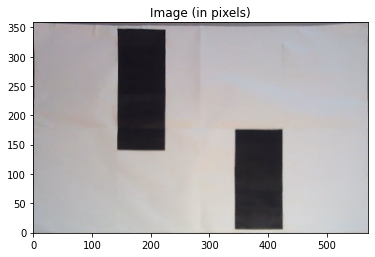

In [7]:
%matplotlib inline

map = mpimg.imread("figures/map2.jpg")

fig, ax = plt.subplots(1)
ax.imshow(map[::-1])
ax.set_title('Image (in pixels)')
plt.gca().invert_yaxis()

The scaling from pixel to mm coordinates is shown below. The map is made out of 8 A3 size papers. The width (x-direction) is 1188 mm and the height (y-direction) is 840 mm. Note that the coordinate system in images for the x,y directions are flipped. 

In [ ]:
X,Y = image.shape # X and Y are flipped here
pixel2mmx = 840 / X
pixel2mmy = 1188 / Y

# 2. Path Planning


The source code for the path planning algorithms were retrieved from [here](https://pythonrobotics.readthedocs.io/en/latest/modules/path_planning.html).

## Voronoi diagrams (voronoi_road_map.py)
Voronoi diagrams are used for path planning because the path found maximizes the clearance between the robot and the obstacles. The Voronoi algorithm computes the distance between the nearest obstacle and each point in the free space using Dijkstra's algorithm. Since there will not be any localization with the short range sensors on Thymio and the path being longer than the optimal length is not an issue, Voronoi path planning is a good option to ensure that the robot does not hit any obstacles by accident. For example, when we used A* to compute the path, the algorithm returned paths that hugged the obstacles tightly at certain areas since it is trying to minimize the length of the path.
 

The map image is passed into the *get_path* function to get the x,y coordinates of the Voronoi path. All units are in mm. The start and goal positions must correspond to empty spaces in the map.

A border is added to the map image. The image is then scaled from pixel to coordinates using scaling factors. Then, the image size is reduced by a user defined factor. This factor will determine how dense the grid size of the map will be, which in turn affects the number of points in the found path. The following code demonstrates the Voronoi path planning algorithm.

Voronoi path planning is starting...


<IPython.core.display.Javascript object>


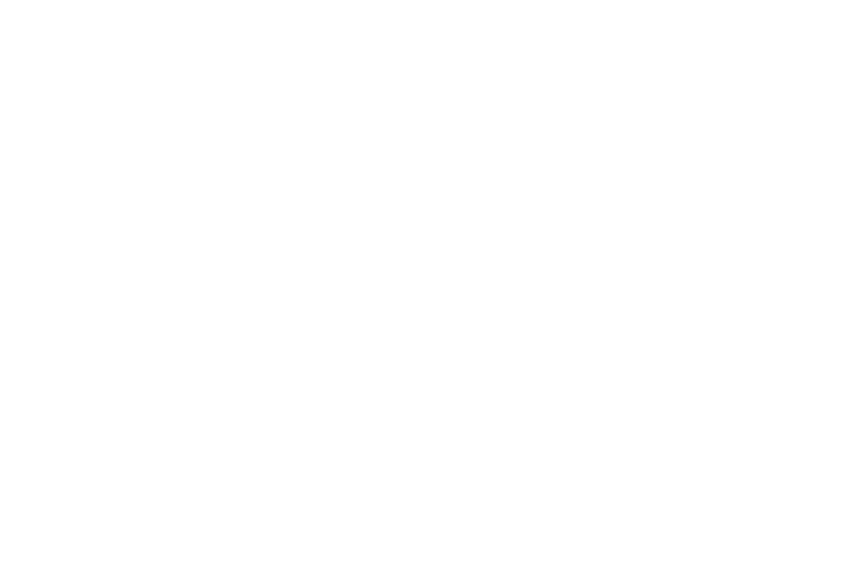

goal is found!


<IPython.core.display.Javascript object>


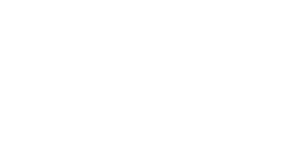

In [10]:
from dijkstra_search import DijkstraSearch
from scipy.spatial import cKDTree, Voronoi
from voronoi_road_map import VoronoiRoadMapPlanner, get_path

%matplotlib notebook
# MAKE SURE IT WORKS IN JUPYTER NOTEBOOK (COLAB NOT WORKING)

# Name of image to load
im = 'figures/map2.jpg'
img = cv2.imread(im, cv2.IMREAD_GRAYSCALE) # read in gray scale

start = np.array([130, 650]).astype(int)
end = np.array([1050, 200]).astype(int)

show_animation = True
path = get_path(img,show_animation,start,end)


(-0.5, 1919.5, 1080.5, -0.5)

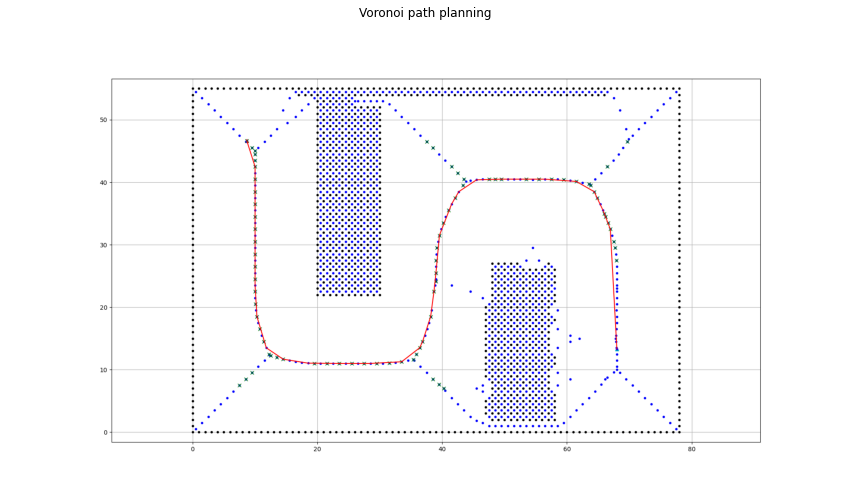

In [11]:
%matplotlib inline

map = mpimg.imread("report_plots/voronoi.png")

fig, ax = plt.subplots(1,figsize=(15, 15))
ax.imshow(map)
ax.set_title('Voronoi path planning')
plt.axis('off')

## Probabilistic road maps (prm.py)

/Users/mikqs/Documents/Autumn 2020/MICRO-452/mobile-robotics/path_planning/prm.py start!!
goal is found!


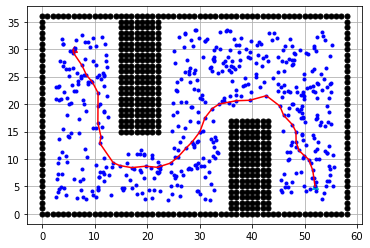

In [12]:
from path_planning import prm

prm.main()

In the probabilisitc road map algorithm, we start by sampling random points on the map. The algorithm then connects all points to form edges that are not obstructed by the obstacles. This creates a network of "roads" where each plausible point is connected. To find the shortest path from the start to goal position, we use Dijkstra's algorithm to find the adjacent node with the shortest distance.

We decided to not use PRM for our demonstration as it generated paths with several short segments. This would take the robot a long time to traverse to the end goal as it would be constantly switching between moving forward and turning.

Additionally, if we had increased the edge lengths and worked with a more complicated environment, then there may exist a potential failure if the sampling density had been too low.

## Rapidly-exploring random trees (rrt.py)

start /content/mobile-robotics/path_planning/rrt.py
found path!!


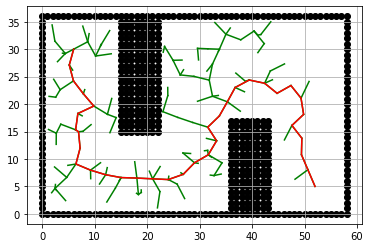

In [ ]:
from path_planning import rrt

rrt.main()

The rapidly-exploring random trees algorithm works similarly to PRM. In RRT, random samples are also generated in free space and connected to form a graph. However, the sampling is a bit different where each node is connected to a single parent. This forms the "branch" like structure of a tree.

The algorithm tends to search for possible points in free space that are defined by a certain distance from the parent branch. The algorithm continues to search and expand its branches using this threshold with the next iteration.

We decided not to use RRT due to the computation time required. The path planning takes several minutes to generate a path that is scaled down 20x. On the original map, the path generation may potentially take hours to compute. Increasing the distance threshold may help, but may be less accurate.

## Set goal position (match_template from get_video.py)
In order to change the goal position, template matching was used. The goal is defined as the location of the coronavirus sticker. At the beginning, a picture of the map is taken and saved. The location of the coronavirus sticker is found by finding the location of a template image of the coronavirus sticker in the same scale within the map. Many of the built in template matching methods in OpenCV worked well. The TM_SQDIFF_NORMED method was chosen as it consistently correctly found the location of the template image within the map. The center of the template image is returned and is set to be the goal position.

The source code was retrieved from [here](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_template_matching/py_template_matching.html).

(-0.5, 1627.5, 508.5, -0.5)

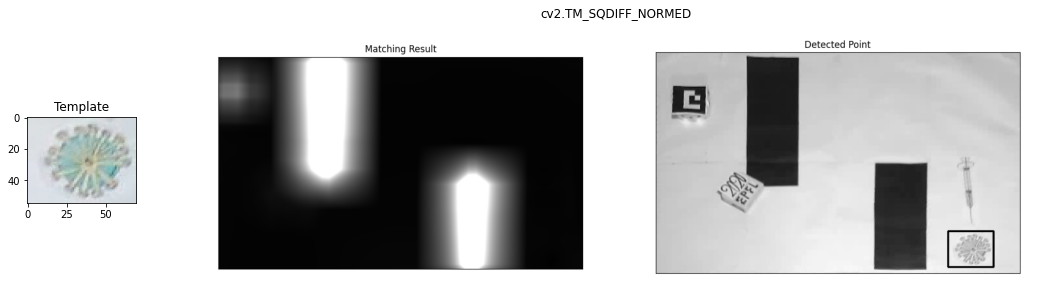

In [13]:
%matplotlib inline

match = mpimg.imread("report_plots/template_matching.png") # image updated in repo but not loading properly?
template = mpimg.imread("camera/template.jpg")

fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 8]},figsize=(15, 15))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
ax[0].imshow(template)
ax[0].set_title('Template')
ax[1].imshow(match)
ax[1].set_title('cv2.TM_SQDIFF_NORMED')
plt.axis('off')

# 3. Motion Control & Filtering

## Robot object definition (motion.py)
We define the Robot class to represent our Thymio. 
The class handles the Thymio instantiation, its state representation, and the different actions it can perform. 
Indeed, it makes possible to get and set the absolut position and the speed of Thymio, to turn to a certain angle, to go to a certain distance or to move to specific coordinates position. This function is using the quadrant of the cartesian plane to determine the correct angle and distance to reach the given coordinates. To find the relate time to sweeped distance and sweeped angle we measured the displacement per time with a ruler and a protractor and found that it was aproximatively linear as seen in the Excel file *Thymio_calibration.xlsx*. The following code example is showing some of the methods from the Robot class.



In [ ]:
from Thymio import Thymio
from motion import Robot
from motion import RepeatedTimer

th = Thymio.serial(port='COM5', refreshing_rate=0.1) #/dev/ttyACM0 for linux, #/dev/cu.usbmodem141101
my_th = Robot(th)
my_th.set_position([0,0,0]) #Set a new absolut position of the robot
my_th.get_position()#Get the absolut position of the robot
my_th.set_speed(100) #Set the speed of the robot
my_th.get_speed() #return the speed of the robot in mm/s

time.sleep(1) 
variables = th.variable_description()
print(variables[0]) 

my_th.move_to_target([20,10])#Move the robot to the given coordinates
my_th.go_straight(distance=20, verbose=True)#Move the robot to a given distance in mm
my_th.turn(60, verbose=False)# Move the robot to a certain angle in degree
my_th.stop() #Stop the robot


## Extended Kalman Filter implementation (ekf.py)
The Thymio moves along the path by reaching specific targets with forward and angular velocity inputs given for a specific amount of time. This simple control method comes at a heavy accuracy cost. To send accurate control inputs, our robot must have an accurate estimate of its position at all times. This position is obtained from odometry and corrected with the camera through an Extended Kalman Filter to compensate for noisy or lossy data. We chose this filter because it allows for easy sensor fusion with assumed Gaussian noise, and is the optimal filter for linear dynamics. EKF also provides us with a fair estimate for non-linear dynamics via a first order Taylor Series approximation.

The main ingredients for the EKF is an accurate state representation, a state transition model (also called process or motion model), and a measurement model (also called observation model).

For simplicity, we assume two independent actions that our differential drive can take: going straight at a forward velocity v and turning on its center of mass at an angular velocity $\omega$. Our state representation will then include the 3 DOFs of the differential drive (the x, y coordinates and the heading angle $\theta$), and the forward and angular velocity inputs. The last two parameters are independent in theory. 

While we run our path following loop, we start a different thread using the Python timer *filter_position*. This timer runs a function at every $\Delta t = 0.1 s$ that measures the speed at the wheels using the *Robot.get_speed* method defined above, computes the associated inputs with *ekf.calc_input*, and measures the robot position (x, y, $\theta$) with the *ekf.observation* method from the camera. This will characterize our measurement model.
The prediction and correction steps of the EKF algorithm are then invoked in the *ekf.ekf_estimation* method from the file to retrieve the estimated position and error covariance *xEst* and *PEst*. This corrected position is then fed back to the robot's state with the *Robot.set_position* method defined above.

Both models have a covariance matrix representing their associated noise. 
To model the noise associated with the forward and angular speed, we measured the of speeds at each wheel at every $0.1 \ s$ over a sweeped distance of $1000 \ mm$ and then an angle of $1800$ &deg;, averaged the left and right wheel speeds, and computed the variance of the dataset. We then assumed that half of this variance was due to the transition error and half of it was due to measurement error: $\sigma^q_v$ = $\sigma^r_v$ = $2.44539 \ mm/s$ 
and $\sigma^q_{\omega}$ = $\sigma^r_{\omega}$ = $0.00114760 \ rad/s$.\
For the noise associated with measuring the position, we assumed that the process noise had a $\sigma^q_x$ = $\sigma^q_y$ = 10 mm and $\sigma^q_{\theta}$ = 10&deg; error off resulting from our manual calibration error. The position measurement noise from the camera was assumed to be $\sigma^r_x$ = $\sigma^r_y$ = 2 mm and $\sigma^r_{\theta}$ = 2.5&deg;

### Motion model

$$x_{k+1} = Fx_k + Bu_k + w_k = \begin{bmatrix}1 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0
\end{bmatrix} . 
\begin{bmatrix} p^x_k \\ p^y_k \\ \theta_k \\ v_k \\ \omega_k \end{bmatrix} +  \begin{bmatrix} \Delta t * cos(\theta_k) & 0 \\ \Delta t * sin(\theta_k) & 0\\ 0 & \Delta t\\ 1 & 0 \\ 0 & 1 \end{bmatrix} . 
\begin{bmatrix} v_k \\ \omega_k
\end{bmatrix} + w_k$$ 

### Measurement model

$$z_{k} = Hx_k + v_k = \begin{bmatrix}1 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 1
\end{bmatrix} . \begin{bmatrix} p^x_k \\ p^y_k \\ \theta_k \\ v_k \\ \omega_k \end{bmatrix} + \nu_k$$

### Process and measurement noise

 $w_k \sim 𝒩(0,Q)$ is the process noise which that is assumed to be zero-mean Gaussian with the covariance:

$$Q = \begin{bmatrix}10^2 \ mm^2 & 0 & 0 & 0 & 0 \\
0 & 10^2 \ mm^2 & 0 & 0 & 0\\
0 & 0 & 0.17454^2 \ rad^2 & 0 & 0\\
0 & 0 & 0 & 2.44539^2 \ mm^2/s^2 & 0\\
0 & 0 & 0 & 0 & 0.00114760^2 \ rad^2/s^2
\end{bmatrix}$$

$$Q = \begin{bmatrix}(\sigma^q_x)^2 & 0 & 0 & 0 & 0 \\
0 & (\sigma^q_y)^2 & 0 & 0 & 0\\
0 & 0 & (\sigma^q_{\theta})^2 & 0 & 0\\
0 & 0 & 0 & (\sigma^q_v)^2 & 0\\
0 & 0 & 0 & 0 & (\sigma^q_\omega)^2
\end{bmatrix}$$

Speed variances computed from speed values over sweeped distance of $1000 \ mm$ or an angle of $1800$&deg;.

Assume half of $v$ and $\omega$ error comes from transition and other half from measurement:\
$\sigma^q_v$ = $\sigma^r_v$ = $2.44539 \ mm/s$ 
and $\sigma^q_{\omega}$ = $\sigma^r_{\omega}$ = $0.00114760 \ rad/s$ 

Assume the following covariances for $x, y, \theta$ process and measurement noise:\
$\sigma^q_x$ = $\sigma^q_y$ = 10 mm and $\sigma^q_{\theta}$ = 10&deg; = $0.17454\ rad$\
$\sigma^r_x$ = $\sigma^r_y$ = 2 mm and $\sigma^r_{\theta}$ = 2.5&deg; = $0.0436\ rad$


 $\nu_k \sim 𝒩(0,R)$ is the measurement noise which that is assumed to be zero-mean Gaussian with the covariance:

$$R = \begin{bmatrix}2^2 \ mm^2 & 0 & 0 & 0 & 0 \\
0 & 2^2 \ mm^2 & 0 & 0 & 0\\
0 & 0 & 0.0436^2 \ rad^2 & 0 & 0\\
0 & 0 & 0 & 2.44539^2 \ mm^2/s^2 & 0\\
0 & 0 & 0 & 0 & 0.00114760^2 \ rad^2/s^2
\end{bmatrix}$$

$$R = \begin{bmatrix}(\sigma^r_x)^2 & 0 & 0 & 0 & 0 \\
0 & (\sigma^r_y)^2 & 0 & 0 & 0\\
0 & 0 & (\sigma^r_{\theta})^2 & 0 & 0\\
0 & 0 & 0 & (\sigma^r_v)^2 & 0\\
0 & 0 & 0 & 0 & (\sigma^r_\omega)^2
\end{bmatrix}$$

## Further work on curved motion and differential drive kinematics

We could have manipulated the ratio of speeds $v_r/v_l$ between the wheel to engage in smooth curved motion, however this complicates speed calibration as we have to manually measure the time taken for the robot to go from point A to point B for each ratio of speed, and this model becomes non-linear. We were motivated enough to solve the equations of motion defined [in this report, page 5](https://www.usna.edu/Users/cs/crabbe/SI475/current/mob-kin/mobkin.pdf) using [WolframAlpha (see the 6th solution, x/y will be that ratio, and O will be the angle)](https://www.wolframalpha.com/input/?i=solve+A+%3D+%28x%2By%29%2F%28x-y%29+*+p%2F2+*+sin+%28%28x-y%29%2Fp*t%29%3B+B+%3D+%28x%2By%29%2F%28x-y%29*p%2F2%281-cos%28%28x-y%29%2Fp*t%29%29%3B+O+%3D+%28x+-+y%29%2Fp+*+t). 


## Thymio Kidnapping demonstration

The below plot shows the Extended Kalman Filter path correction with the robot kidnapping (video shown at the top of this report):

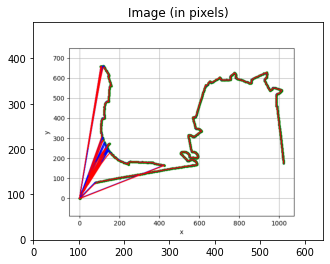

In [16]:
%matplotlib inline

map = mpimg.imread("figures/ekf_kidnapping.png")

fig, ax = plt.subplots(1)
ax.imshow(map[::-1])
ax.set_title('Image (in pixels)')
plt.gca().invert_yaxis()

## Camera positioning (get_video.py)
ArUco markers were used to find the position and angle of the Thymios from the live camera video feed. ArUco markers are binary square fiducial markers that can be used for camera pose estimation. Detection using these markers is robust, fast, and simple. They are provided in the OpenCV library. The first ArUco mark (ID = 1) of the aruco.DICT_4X4_50 ArUco marker dictionary was used for simplicity.

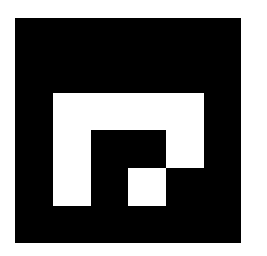



This marker was printed in the size of the Thymio and attached to the top of the robot. The pixel location of the ArUco marker within the image is observed at fixed time intervals. The detect_thymio function returns the robot [x,y] coordinates in mm values based on the fixed pixel to mm scaling factor, along with its angle. The following code demonstrates how the ArUco markers are detected and how the position and angle of the Thymio is calculated.

In [18]:
import numpy as np
import cv2
import cv2.aruco as aruco
import math

aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50) # Get ArUco dictionary

# Detect aruco markers
corners, ids, rejectedImgPoints = aruco.detectMarkers(img, aruco_dict)
corners = np.array(corners)
  
Y,X = img.shape

newPos = np.zeros((5,1)) # initialize position

# Plot identified markers, if any
if ids is not None:
    # Draw location of aruco markers
    frame_markers = aruco.drawDetectedMarkers(img, corners, ids,borderColor = (0,0,255)) # convert back to RGBA

    pos = np.empty((len(ids),2))
    vec = np.empty((len(ids),2))
    
    c = corners[0][0] # Find center of marker
        
    pos = np.array([c[:,0].mean()*pixel2mmy,  (Y-c[:,1].mean())*pixel2mmx])
    pos = pos.astype(int)

    vec = (c[1,:] + c[0,:])/2 - (c[2,:] + c[3,:])/2  # Find orientation vector of chair
    vec = vec/ np.linalg.norm(vec) # Convert to unit vector
    ang = math.atan2(vec[0], vec[1])
    
    newPos[0] = pos[0]
    newPos[1] = pos[1]
    newPos[2] = ang

The *init_video* function initializes all the parameters needed for image processing. It takes in the source color frame from the video and the parameter *save_image*. It outputs the warped image in color, the warped image in grayscale, the corner points, and the pixel2mmx and pixel2mmy scaling factors. These are all the values that are needed to process the live images from the video feed and detect the location of the Thymio live.

# 4. Avoiding Local Obstacles


To avoid obstacles in the robot's path we implemented concurrent programming methods. A separate thread is used to check if there is an obstacle repeatedly. For obstacle detection we use the horizontal proximity sensors. When the robot encounters an obstacle, it will suspend the path following thread to avoid the obstacle then come back to the correct path once the obstacle has been successfully avoided. 
This thread is implemented in the initializer of the class *Robot* and called in the method *test_saw_wall* every 0.4s. If the robot sees an obstacle, it will stop the thread, put the flag *flag_local* to *True*. This will indicate to the following path thread to wait. The method *time_move* in the class *Robot* checks the status of the flag and waits the desired time to reach a distance.
Then, we call the method *wall_following*. This method will avoid the obstacle by first turning to the right, then going forward, and then going slightly to the left again to check if there is still an obstacle. If the obstacle is still here, it will go to the right again and repeat this process of checking for the obstacle. If the obstacle is no longer there, it will continue to check for the obstacle in the same manner for 15 times. After 15 successive times of not detecting any obstacles, we consider that the obstacle is avoided. We then skip the next 2 points in the planned path trajectory and we start again the path following thread. We assume that our obstacles are too big (for example, the size of a Thymio). Hence, a reasonable choice is to skip 2 points of the path that may be overlapping with the obstacle, such that no turning back is done when the local avoidance mode is completed.


In [ ]:
from Thymio import Thymio
from motion import Robot
from motion import RepeatedTimer

th = Thymio.serial(port='COM5', refreshing_rate=0.1) #/dev/ttyACM0 for linux, #/dev/cu.usbmodem141101
my_th = Robot(th) #constructor, start the local avoidance thread
#will start the local advoidance code if there is an obstacle

# Conclusion

Using the Voronoi diagram for path planning ensured that we did not hit any obstacles. The path found was sufficiently optimized so that the robot was able to move from the start to the goal position in an efficient manner. We also investigated other global path planning algorithms including A*, PRM, and RRT. However, they either did not provide enough clearance between the robot and the obstacle, or it took too long to compute. Thus, Voronoi diagrams were used to path plan.

We used a simple motion model where the robot is only turning or going straight. Since the robot is moving in small increments, this worked well for us. However, we could have used a complete motion model that changes the speed of both wheels to create smoother motion. This is something we would have done provided we had more time for this project.

In terms of filtering we found that the EKF worked very well as we were able to do kidnapping with the robot and have it find it's path again. The live camera feed using ArUco markers was acurate. 

Obstacle avoidance can be improved by using a more sophisticated model to determine whether the robot has returned to path. However, our current system worked well given that we have many points in our trajectory that are fairly close together.

Integrating the different components of the code was the most difficult part of the project. There were many issues with getting different tasks to run at the same time and work together. We used Github to manage our project. We learned a lot about how to manage software projects with several contributors. It is important to collaborate with others on the code and to make sure to test the code first before pushing it into Github. We also found many other open source code and projects in python related to mobile robotics that are interesting and useful for any future projects. Overall the project was fun and we learned to apply theoretical knowledge learned in lectures to practical applications.

# References

1. Path Planning algorithms (Voronoi, A*, PRM, RRT) \\
https://pythonrobotics.readthedocs.io/en/latest/modules/path_planning.html

2. Differential drive kinematics \\
http://www.cs.columbia.edu/~allen/F15/NOTES/icckinematics.pdf \\
https://www.usna.edu/Users/cs/crabbe/SI475/current/mob-kin/mobkin.pdf

3. Youngjoo Kim and Hyochoong Bang (November 5th 2018). Introduction to Kalman Filter and Its Applications, Introduction and Implementations of the Kalman Filter, Felix Govaers, IntechOpen, DOI: 10.5772/intechopen.80600. Available from: https://www.intechopen.com/books/introduction-and-implementations-of-the-kalman-filter/introduction-to-kalman-filter-and-its-applications

4. Thymio Wiki \\
http://wiki.thymio.org/en:thymio

5. "4 Point OpenCV getPerspective Transform Example" by Adrian Rosebrock (August 25, 2014) \\
https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/


# Notes
The *add_trajectory* function is used to overlay the planned trajectory and goal position onto the recorded video.